N - L - R - V(PVC) - /(PB)      99.55     balance  inrease (IR=3)

In [ ]:
import wfdb
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

records = [f'I{str(i).zfill(2)}' for i in range(1, 76)]

window_size = 100 
after_size = 200   

def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

lowcut = 0.5   
highcut = 45.0 

all_segments = []
all_labels = []

print("Processing INCART Records...")
for record_name in tqdm(records):
    try:
        record = wfdb.rdrecord(record_name)
        annotation = wfdb.rdann(record_name, 'atr')

        signal = record.p_signal[:, 0]  
        fs = record.fs

        filtered_signal = bandpass_filter(signal, lowcut, highcut, fs)

        r_peaks = annotation.sample
        symbols = annotation.symbol

        for i, r in enumerate(r_peaks):
            if r - window_size >= 0 and r + after_size < len(filtered_signal):
                segment = filtered_signal[r - window_size:r + after_size]
                label = symbols[i]
                all_segments.append(segment)
                all_labels.append(label)

    except Exception as e:
        print(f"Error processing {record_name}: {e}")
        continue

all_segments = np.array(all_segments)
all_labels = np.array(all_labels)

all_segments = (all_segments - np.min(all_segments)) / (np.max(all_segments) - np.min(all_segments))
all_segments = 2 * all_segments - 1

aami_mapping = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S',
    'V': 'V', 'E': 'V'
}

aami_labels = [aami_mapping.get(lbl, None) for lbl in all_labels]

valid_indices = [i for i, lbl in enumerate(aami_labels) if lbl is not None]
X_filtered = all_segments[valid_indices]
y_filtered = np.array([aami_labels[i] for i in valid_indices])

X = X_filtered[:, :, np.newaxis]  

le = LabelEncoder()
y = le.fit_transform(y_filtered)

print(f"\n✅ Shape of X: {X.shape}")
print(f"✅ Shape of y: {y.shape}")
print("✅ Class labels mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print("✅ Class distribution:", Counter(y))


Processing INCART Records...


100%|██████████| 75/75 [00:07<00:00, 10.14it/s]



✅ Shape of X: (175530, 300, 1)
✅ Shape of y: (175530,)
✅ Class labels mapping: {'N': 0, 'S': 1, 'V': 2}
✅ Class distribution: Counter({0: 153585, 2: 20003, 1: 1942})


In [ ]:
import numpy as np
from collections import Counter

def augment_data_to_balance(X, y):
    X = list(X)
    y = list(y)

    label_counts = Counter(y)
    print(f'Original label distribution: {label_counts}')

    majority_label, max_count = label_counts.most_common(1)[0]
    
    new_X = []
    new_y = []

    for label in label_counts:
        if label == majority_label:
            continue  

        label_count = label_counts[label]
        class_samples = [X[i] for i in range(len(y)) if y[i] == label]

        num_required = max_count - label_count
        print(f'Class "{label}" needs {num_required} more samples.')

        for i in range(num_required):
            signal = class_samples[i % len(class_samples)]

            noise = np.random.normal(0, 0.005, signal.shape)
            scale = np.random.uniform(0.95, 1.05)
            shift = np.random.randint(-5, 5)
            shifted = np.roll(signal, shift)
            if shift > 0:
                shifted[:shift] = 0
            elif shift < 0:
                shifted[shift:] = 0

            aug_methods = [signal + noise, signal * scale, shifted]
            aug_signal = aug_methods[i % len(aug_methods)]

            new_X.append(aug_signal)
            new_y.append(label)

    X.extend(new_X)
    y.extend(new_y)

    label_counts = Counter(y)
    print(f'Final label distribution: {label_counts}')
    
    return np.array(X), np.array(y)

balanced_X, balanced_y = augment_data_to_balance(X, y)

label_counts = Counter(balanced_y)
print(f'Balanced class counts: {label_counts}')


Original label distribution: Counter({0: 153585, 2: 20003, 1: 1942})
Class "2" needs 133582 more samples.
Class "1" needs 151643 more samples.
Final label distribution: Counter({0: 153585, 2: 153585, 1: 153585})
Balanced class counts: Counter({0: 153585, 2: 153585, 1: 153585})


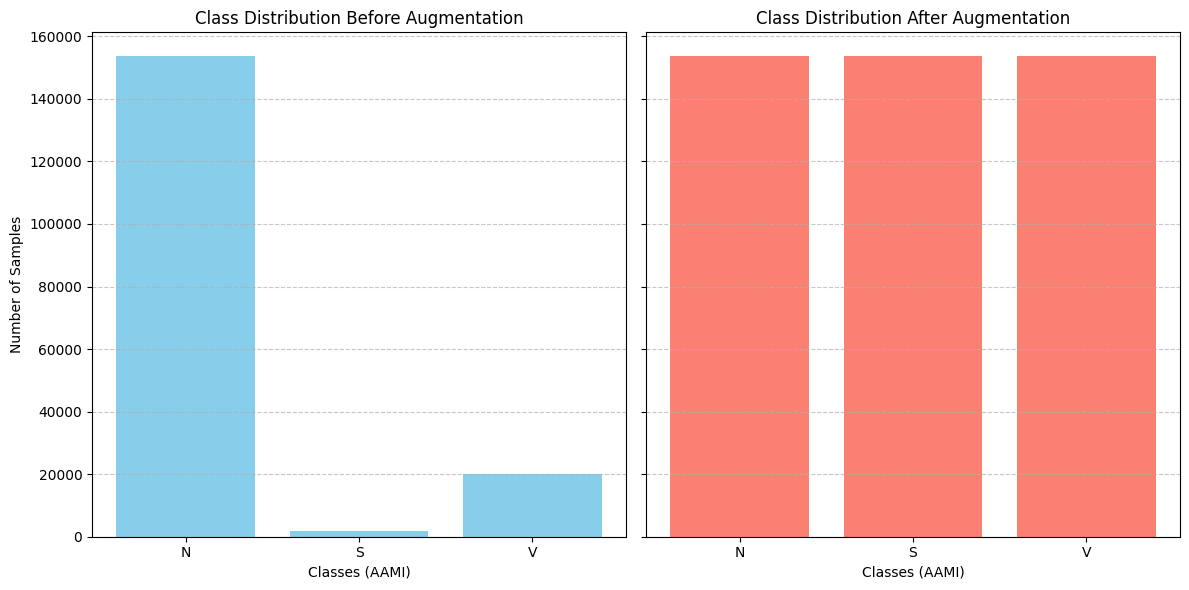

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

original_class_counts = Counter(y)
augmented_class_counts = Counter(balanced_y)

class_ids = sorted(original_class_counts.keys()) 
class_names = le.inverse_transform(class_ids)     

original_counts = [original_class_counts[c] for c in class_ids]
augmented_counts = [augmented_class_counts[c] for c in class_ids]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].bar(class_names, original_counts, color='skyblue')
axes[0].set_title('Class Distribution Before Augmentation')
axes[0].set_xlabel('Classes (AAMI)')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(class_names, augmented_counts, color='salmon')
axes[1].set_title('Class Distribution After Augmentation')
axes[1].set_xlabel('Classes (AAMI)')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
balanced_X = balanced_X.reshape(-1, balanced_X.shape[1])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
balanced_X = scaler.fit_transform(balanced_X)  

In [14]:
balanced_X.shape

(460755, 300)

In [15]:
balanced_y.shape

(460755,)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.expand_dims(balanced_X, axis=-1)  

X_train, X_test, y_train2, y_test2 = train_test_split(
    X, balanced_y, test_size=0.2, random_state=42, stratify=balanced_y
)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train2)
y_test = encoder.transform(y_test2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

input_shape = X_train.shape[1:]
inputs = tf.keras.Input(shape=input_shape)

# --- Encoder ---
x = layers.Conv1D(128, 5, activation='relu', strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(64, 5, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

encoded = x

# --- Decoder ---
x = layers.Conv1DTranspose(64, 5, activation='relu', strides=2, padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

decoded = layers.Conv1DTranspose(1, 5, activation='tanh', strides=2, padding='same')(x)

autoencoder = models.Model(inputs, decoded)
encoder_model = models.Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

print("Training Autoencoder...")
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[ReduceLROnPlateau(patience=5, factor=0.5)]
)

X_train_features = encoder_model.predict(X_train)
X_val_features = encoder_model.predict(X_val)
X_test_features = encoder_model.predict(X_test)

print("Shapes of encoded features:")
print(X_train_features.shape, X_val_features.shape, X_test_features.shape)





Training Autoencoder...
Epoch 1/50

5184/5184 [==============================] - 161s 30ms/step - loss: 0.0047 - val_loss: 3.8313e-04 - lr: 0.0010
Epoch 2/50
5184/5184 [==============================] - 156s 30ms/step - loss: 2.8189e-04 - val_loss: 3.7431e-04 - lr: 0.0010
Epoch 3/50
5184/5184 [==============================] - 156s 30ms/step - loss: 1.5712e-04 - val_loss: 2.7237e-04 - lr: 0.0010
Epoch 4/50
5184/5184 [==============================] - 157s 30ms/step - loss: 1.2310e-04 - val_loss: 1.4621e-04 - lr: 0.0010
Epoch 5/50
5184/5184 [==============================] - 155s 30ms/step - loss: 1.1100e-04 - val_loss: 3.0208e-04 - lr: 0.0010
Epoch 6/50
5184/5184 [==============================] - 156s 30ms/step - loss: 1.0422e-04 - val_loss: 2.8410e-04 - lr: 0.0010
Epoch 7/50
5184/5184 [==============================] - 156s 30ms/step - loss: 9.9386e-05 - val_loss: 2.6846e-04 - lr: 0.0010
Epoch 8/50
5184/5184 [==============================] - 155s 30ms/step - loss: 9.7177e-05 - va

Training Transformer...
Epoch 1/30
10367/10367 [==============================] - 389s 37ms/step - loss: 0.5060 - accuracy: 0.7664 - val_loss: 0.3069 - val_accuracy: 0.8843 - lr: 1.0000e-04
Epoch 2/30
10367/10367 [==============================] - 371s 36ms/step - loss: 0.2373 - accuracy: 0.9120 - val_loss: 0.1690 - val_accuracy: 0.9391 - lr: 1.0000e-04
Epoch 3/30
10367/10367 [==============================] - 368s 36ms/step - loss: 0.1595 - accuracy: 0.9436 - val_loss: 0.1151 - val_accuracy: 0.9598 - lr: 1.0000e-04
Epoch 4/30
10367/10367 [==============================] - 369s 36ms/step - loss: 0.1295 - accuracy: 0.9545 - val_loss: 0.1016 - val_accuracy: 0.9637 - lr: 1.0000e-04
Epoch 5/30
10367/10367 [==============================] - 368s 36ms/step - loss: 0.1106 - accuracy: 0.9608 - val_loss: 0.1015 - val_accuracy: 0.9639 - lr: 1.0000e-04
Epoch 6/30
10367/10367 [==============================] - 368s 36ms/step - loss: 0.0972 - accuracy: 0.9654 - val_loss: 0.0719 - val_accuracy: 0.97

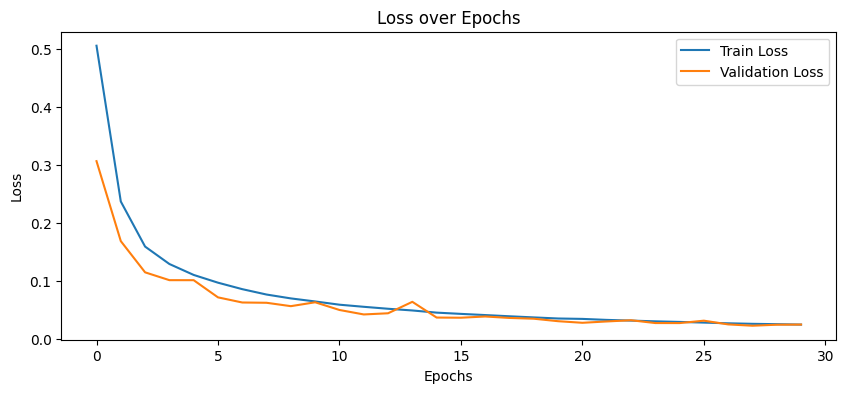

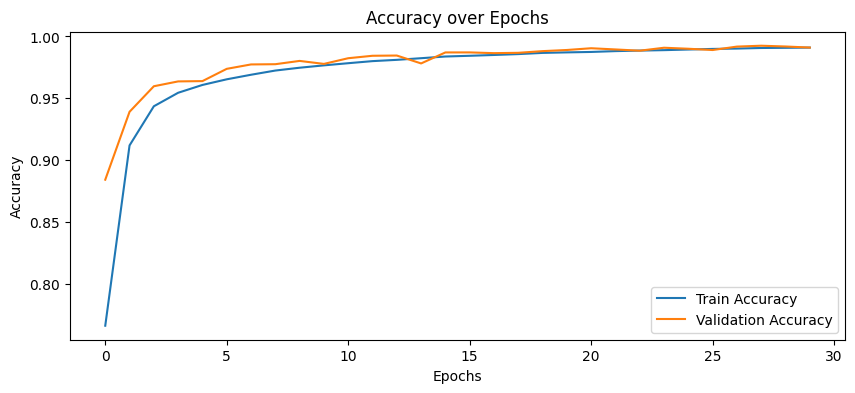

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        pos = np.arange(maxlen)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Transformer Encoder Block
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.input_dim = num_heads * key_dim
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(self.input_dim)
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        attn_output = self.attention(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        x = self.norm1(x + attn_output)

        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.norm2(x + ffn_output)
        return x

seq_len = X_train_features.shape[1]
feature_dim = X_train_features.shape[2]

inputs = layers.Input(shape=(seq_len, feature_dim))
x = PositionalEncoding(seq_len, feature_dim)(inputs)

num_heads = 4
key_dim = feature_dim // num_heads
ff_dim = 256

for _ in range(2):
    skip = x
    x = TransformerEncoderBlock(num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim)(x)
    x = layers.Add()([x, skip])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

residual_dense = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(512, activation='relu')(residual_dense)
x = layers.Dropout(0.2)(x)
x = layers.LayerNormalization()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.LayerNormalization()(x)

x = layers.Dense(128, activation='relu')(x)

residual_mapped = layers.Dense(128)(residual_dense)
x = layers.Add()([x, residual_mapped])
x = layers.LayerNormalization()(x)

output = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

transformer_model = models.Model(inputs=inputs, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
transformer_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6, verbose=1)

print("Training Transformer...")
history = transformer_model.fit(
    X_train_features, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_features, y_val),
    callbacks=[lr_scheduler]
)

y_pred = transformer_model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

test_loss, test_accuracy = transformer_model.evaluate(X_test_features, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


<Figure size 600x500 with 0 Axes>

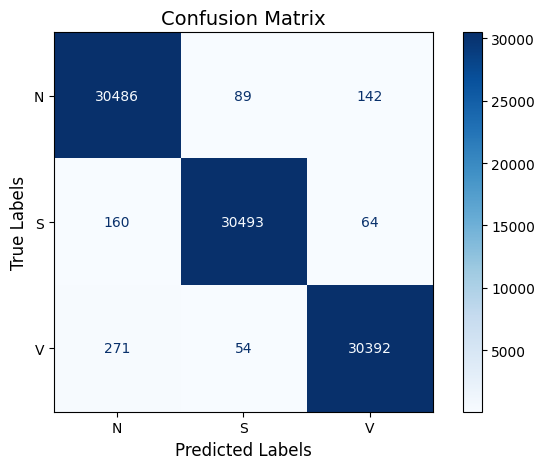

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes, labels=[0, 1, 2])

label_map = {
    0: 'N',
    1: 'S',
    2: 'V'
}
display_labels = [label_map[i] for i in [0, 1, 2]]

plt.figure(figsize=(6, 5))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot(cmap=plt.cm.Blues, colorbar=True, values_format='d') 

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()
plt.show()


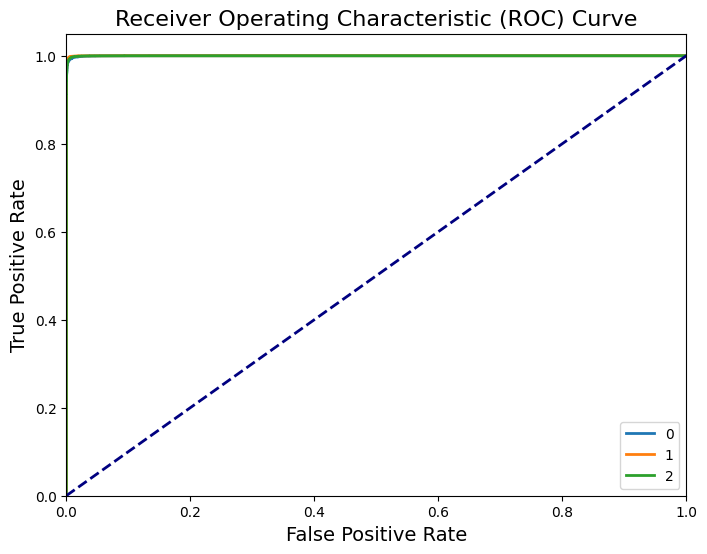

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

class_label_mapping = {
    'N': 'N',
    'S': 'St',
    'V': 'V',
}

plt.figure(figsize=(8, 6))

for i in range(len(encoder.classes_)):
    y_test_binary = (y_test == i).astype(int)
    y_pred_class = y_pred[:, i]

    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_class)
    
    class_name = class_label_mapping.get(encoder.classes_[i], encoder.classes_[i])
    
    plt.plot(fpr, tpr, lw=2, label=f'{class_name}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

plt.legend(loc="lower right", fontsize=10)

roc_output_path = "image/roc_curve_no_auc.pdf"
plt.show()
